# Near Real-time Analytics for Intelligent Manufacturing
```text
                DQ 2022.04.06
```
[点击这里阅读中文版](RealtimeAnalyticsOnSemistructureData_zh_CN.ipynb) 

I'd like to summarize the new understanding of intelligent manufacturing analysis business scenarios after serving some manufacturing customers recently.

Nowadays, lots of modern manufacturing companies already have automated auxiliary manufacturing equipment, and the manufacturing process has been informationized. A factory will generate lots of detailed process data in the Manufacturing Execution System every day. Most companies hope to collect, process and integrate production, quality, event and other data in near real-time, and analyze the efficiency bottleneck & the defect rate of the production process in various ways such as dashboard, large screen data visualization and reports, thereby improving production efficiency and defect-free rate, reducing waste and production costs, and enhancing the competitiveness of products and companies.

However, large-scale manufacturing companies often have many factories distributed in different geographical locations, and in addition to the structured data in the manufacturing execution system, there are also different kinds & large amount of data from smart device sensor data or system buried points. These are challenges to integrate and analysis them especially in near real-time.

On the one hand, most of these analytics businesses start around the manufacturing execution system, and many companies even run them in the same database from the very beginning. These databases are often traditional transactional databases such as SQL Server or PostgreSQL, which are not very good at analytics, let alone semi-structured sensor or buried point data with higher performance requirements. Even if the database replication technology is used to separate the analysis business, it cannot support the performance requirements of a large volumn of data processing and analysis.

On the other hand, under the influence of "big data is just Hadoop" in previous years, companies have invested a lot of money in building Hadoop-based big data system, but in the end they found that its analysis performance and concurrency throughput were completely unable to meet enterprise-level requirements, let alone the timeliness of insights.

Focusing on real-time analytics of big data from the start, Vertica easily addresses the above challenges faced by customers in the manufacturing industry.

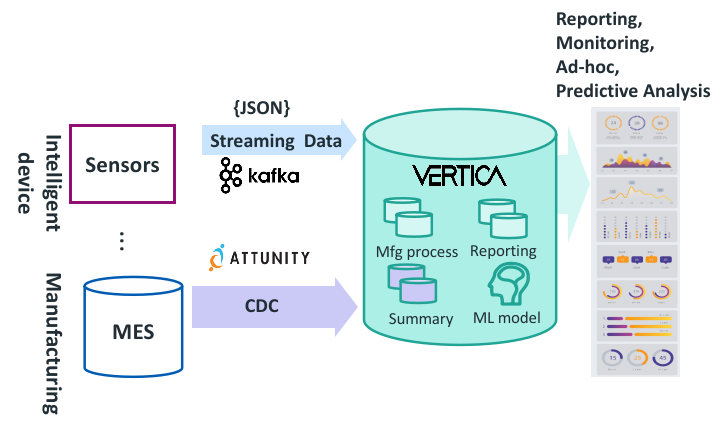

For the data stored in the relational database by the manufacturing execution system, using CDC(Change Data Capture) tools such as Attunity or Informatica, the change data can be replicate to Vertica in near real-time. With Vertica's capabilities from massively parallel processing and columnar storage architecture, when data enters Vertica, wide tables can be populated automatically at the same time, the same data can be segmented, compressed, sorted and even aggregated in different ways for performance of different types of queries with near real-time capabilities. Compared with traditional databases, there is usually a performance improvement of **10~100 times**.

Building on this, Vertica's in-database machine learning capabilities can help train various models for different purposes on the full data. Once data enters Vertica, accurate predictions can be made based on these models. All of this is implemented through SQL, so any visualization tool or application that can execute SQL can leverage those insights to respond to the business quickly.

For massive semi-structured data from smart device sensor or system buried points, you only need to send them to Kafka, and the native Kafka connector of Vertica will automatically pull these messages from Kafka to Vertica in near real-time. Vertica's [Flex Table](https://www.vertica.com/docs/latest/HTML/Content/Authoring/FlexTables/FlexTableHandbook.htm) is designed for the fast loading and analysis scenarios of JSON, CEF logs and other semi-structured data by Schema on Read. There is no need to strictly define the table in advance, semi-structured data can be loaded directly. Analysts can query & do predictive analysis on-demand with SQL on the Flex Table without data processing in advance.

Later in this article, you will see how easy to load JSON semi-structured data in near real-time, optimize data storage for extremely fast performance, and use in-database machine learning for model training and predictive analytics.

## 1. Prerequisites

### 1.1 Prepare the environment

Let's check and install the relevant packages. Matplotlib is a package to show graphics, [**nbmultitask**](https://github.com/micahscopes/nbmultitask/) is a package for running tasks parallelly in Jupyter Notebook.

[**VerticaPy**](https://www.vertica.com/python/) will be used to run queries in Vertica and show data in Jupyter Notebook. Not only this, VerticaPy provides Vertica's scalable performance in-db machine learning capabilities to data scientists with Python interface.

In [1]:
%%!
# make sure that verticapy matplotlib nbmultitask are installed
test 3 -eq \
    $(grep -wE "verticapy\s|matplotlib\s|nbmultitask\s" \
          <<< "$(python3 -m pip list)" | wc -l) \
    || python3 -m pip install -qU verticapy matplotlib nbmultitask \
    || echo "Please manually run: \
           python3 -m pip install -qU verticapy matplotlib nbmultitask"

[]

Then set the connection properties for Vertica database. Please replace property values according to your actual situation.

In [2]:
from verticapy.connect import *

# Set the primary auto-connection
conn_info = {"host": "localhost", 
             "port": "5433", 
             "database": "testdb", 
             "user": "dbadmin",
             "password": "youPassword"
             }
new_auto_connection(conn_info, name = "VerticaDSN")
change_auto_connection("VerticaDSN")

# load SqlMagic extension
%reload_ext verticapy.sql
print(verticapy.__version__)

0.8.1


,AbcVarchar(128)
1,

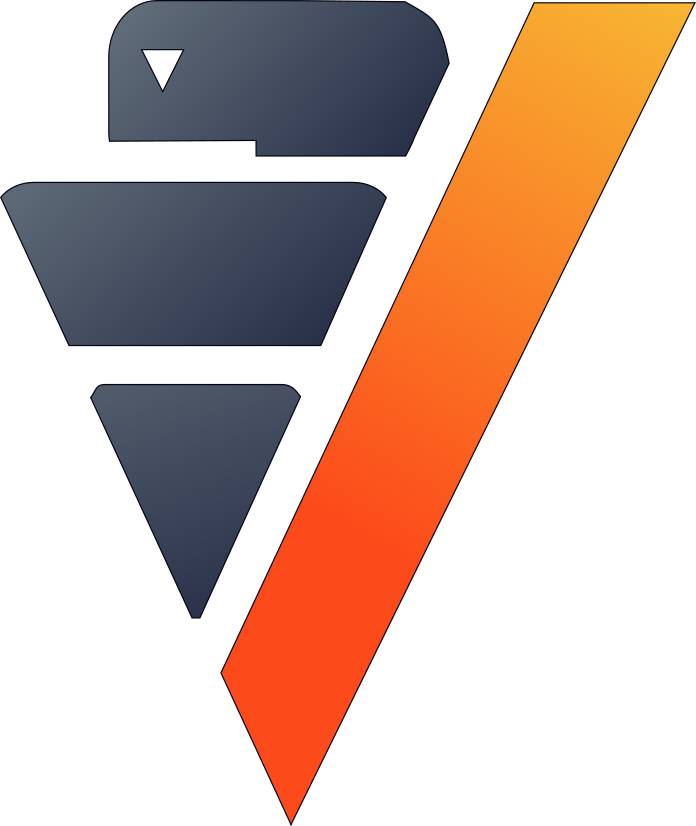

In [3]:
%sql select version();

### 1.2 Create a flex table for schema on read

Flex table of Vertica is designed for the fast loading and query on JSON, CEF logs and other semi-structured data directly without data processing in advance.

In [4]:
%%sql

create flex table if not exists events();

CREATE



## 2. Load semi-structured data in real-time

Applications usually sent semi-structured such as JSON to Kafka, and the native Kafka connector of Vertica will automatically pull them from Kafka to Vertica in near real time.

To simulate loading from Kafka in near real-time , here we generate different versions of JSON data in small batches, and load them asynchronously.

In [5]:
from datetime import datetime
import math
import random

DEVICE_COUNT = 10000

class JSONGenerator:
    def __init__(self, count=65536):
        self.count = count
        
    def read(self, batchSize=1024):
        for i in range(0, (self.count + batchSize - 1) // batchSize):
            time = datetime.now()
            listJSON = []
            for j in range(1, batchSize + 1):
                idx = i * batchSize + j
                if idx <= self.count :
                    device_id = idx % DEVICE_COUNT
                    version = 1 + idx % 2
                    value1 = round(
                        100 * math.tanh(
                            math.pi * 2*((-0.5 +
                                (time.minute*60+time.second)%1800/1800)))
                        + random.gauss(0, 1), 4)
                    value2 = round(
                        100 * math.sin(
                            math.pi * ((-0.5 +
                                (time.minute*60+time.second)%1800/1800))) 
                        + random.gauss(0, 1), 4)
                    listJSON.append( "{%s%s%s}" % ( 
                        f'"time": "{time}"' \
                        f', "device_id": {device_id}' \
                        f', "version": {version}'
                        , f', "value1": {value1}' 
                        , f', "value2": {value2}' if version == 2 else '')
                                   )
            yield "\r\n".join(listJSON) if len(listJSON) > 0 else ""
        return ""


Simply test the generator to check event data with different versions and indicators.

In [6]:
# testing generator
gen = JSONGenerator(4)

for json in gen.read(2):
    print(json)

{"time": "2022-03-30 22:12:08.807573", "device_id": 1, "version": 2, "value1": -52.4903, "value2": -29.9591}
{"time": "2022-03-30 22:12:08.807573", "device_id": 2, "version": 1, "value1": -54.2628}
{"time": "2022-03-30 22:12:08.807814", "device_id": 3, "version": 2, "value1": -53.2603, "value2": -30.6085}
{"time": "2022-03-30 22:12:08.807814", "device_id": 4, "version": 1, "value1": -54.0061}


Here is the asynchronous task to load data in micro-batches.

In [7]:
from nbmultitask import ThreadWithLogAndControls
from time import sleep

# loading a micro batch
def micro_batch(contex, thread_print):
    gen = contex["gen"]
    cur = contex["cur"]
    try:
        json = gen.__next__()
        cur.copy("copy events from stdin PARSER fjsonparser()", json)
        thread_print('loaded: ' + json.split('\n')[-1])
        sleep(1)
    except StopIteration as e:
        thread_print("All data loaded.")
        sleep(1)

Click the "start" button shown behind to start the data loading task. It can be stop and rerun again the task at any time.

In [8]:
# loading json realtime
connection = vertica_python.connect(**conn_info)
cur = connection.cursor()

gen = JSONGenerator(100000000)
contex = {'cur': cur, 'gen': gen.read(10000)}

In [9]:
task = ThreadWithLogAndControls(target=micro_batch, args=(contex,), loop=True, name="exponential growth")
task.control_panel()

Button(button_style='success', description='start', style=ButtonStyle())

Button(button_style='primary', description='watch', style=ButtonStyle())

Button(description='clear log', style=ButtonStyle())

Output()

Note, the above lines of code will show three custom control panel buttons as the following picture for real-time data loading. No surprise they are not re-rendered before re-running.

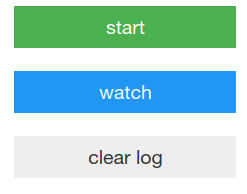

Executing the following cell to feel the real-time change of the data volume during the loading process.

,123countInteger
1,100000000

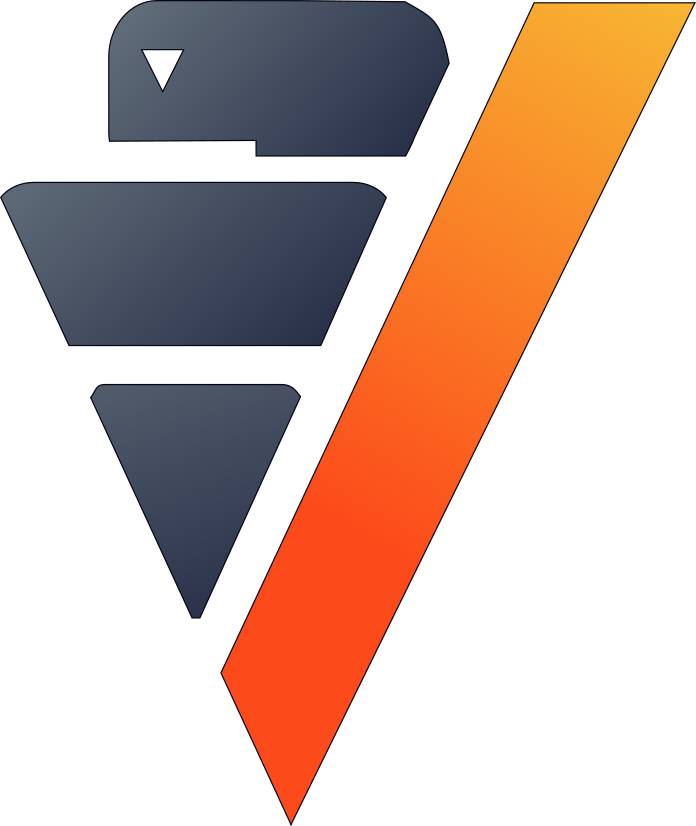

In [10]:
%sql select count(*) from events;

As you can see below, the JSON data is actually parsed and stored in a large binary column named `__raw__` in Vertica. Those attribute names of JSON can be queried directy with SQL, Vertica calls them virtual columns. The JSON data with different contents can be stored and queried together directly, that's the flexibility of the flex table of Vertica.

,AbctimeLong varchar(32000000),Abcdevice_idLong varchar(32000000),AbcLong varchar(32000000)
1,2022-03-27 08:46:49.604250,1,
2,2022-03-27 08:46:49.604250,2,
3,2022-03-27 08:56:04.242867,1,

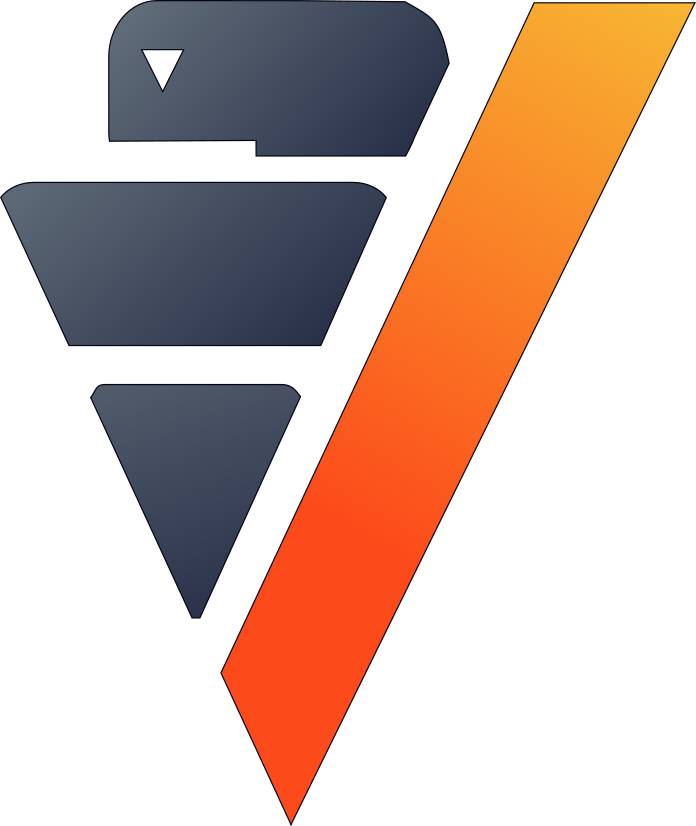

In [11]:
%sql select time, device_id, maptostring(__raw__) from events limit 3

## 3. Storage optimized for real-time analytics

Data deduplication and aggregation are often required. The characteristic of real-time analysis is that it does not have a long time window to prepare data with aggregation and other processing like traditional batching data warehouses. That means, there should be some optimization ways of data storage for better performance of analytical query.

### 3.1 Deduplication

A flex table parses JSON or other semi-structured data to MAP format and stores it directly in a big binary column called `__raw__`. When querying, the database optimizer automatically rewrites the virtual columns in the query to MapLookup function call. E.g,

```sql
select count(distinct device_id::int), max(value1::float) from events;
```

will be rewritten as

```sql
select count(distinct MapLookup(events.__raw__, 'device_id')::int), max(MapLookup(events.__raw__, 'value1')::float) from events;
```

#### 3.1.1 Before optimization

Count device_id without duplicates and calculate the maximum of value1.

,123countInteger,123maxFloat
1,10000,104.9067

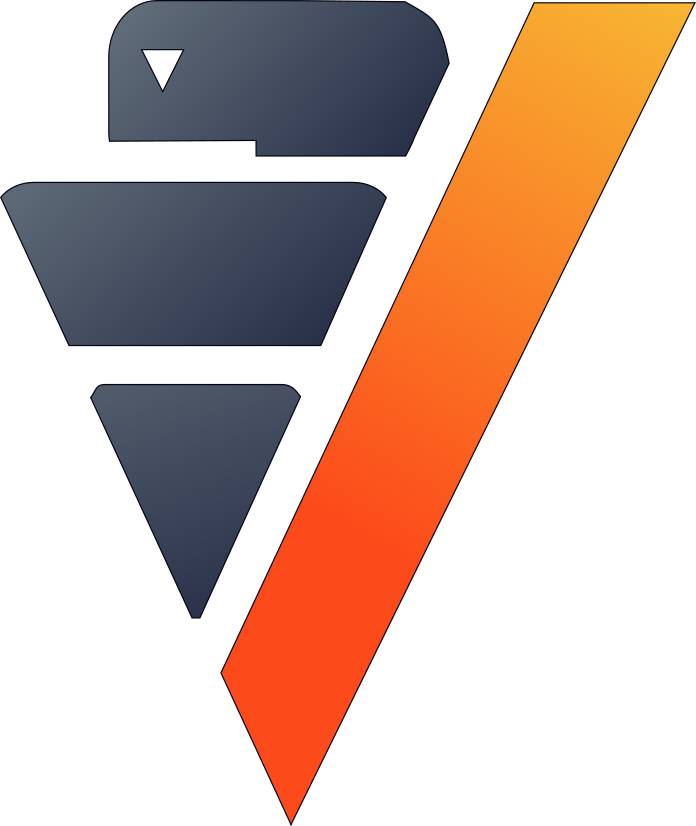

In [12]:
%sql select count(distinct device_id::int), max(value1::float) from events;


#### 3.1.2 Optimization method 1: materialize frequently used virtual columns

The physical columns of a table can be used to distribute data between nodes, with sortness and encoding & compression, and the query performance is usually 1-2 orders of magnitude faster than the virtual columns of a flex table. And if there are physical columns with the same names as virtual columns in a flex table, Vertica will automatically populate values to the physical columns when loading data, eliminating the need to manually maintain them. Therefore, materializing virtual columns is a common method to optimize the query performance of flex tables.

The following steps add frequently used virtual columns to the flex table. The default value expression is added to the new column at the beginning, the purpose is to assign the correct value to the newly added column according to the existing data. Once the column is added, the default value attribute is no longer needed, so just remove it.

In [13]:
%%sql

alter table events 
  add column if not exists device_id int 
  default maplookup(events.__raw__, 'device_id')::int encoding RLE;
alter table events alter column device_id drop default;

alter table events 
  add column if not exists "time" timestamp 
  default maplookup(events.__raw__, 'time')::timestamp;
alter table events alter column "time" drop default;

alter table events 
  add column if not exists "value1" float 
  default maplookup(events.__raw__, 'value1')::float;
alter table events alter column "value1" drop default;

ALTER
ALTER
ALTER
ALTER
ALTER
ALTER


Run this query again with the newly added physical columns, there is usually 1~2 orders of magnitude performance improvement.

,123countInteger,123maxFloat
1,10000,104.9067

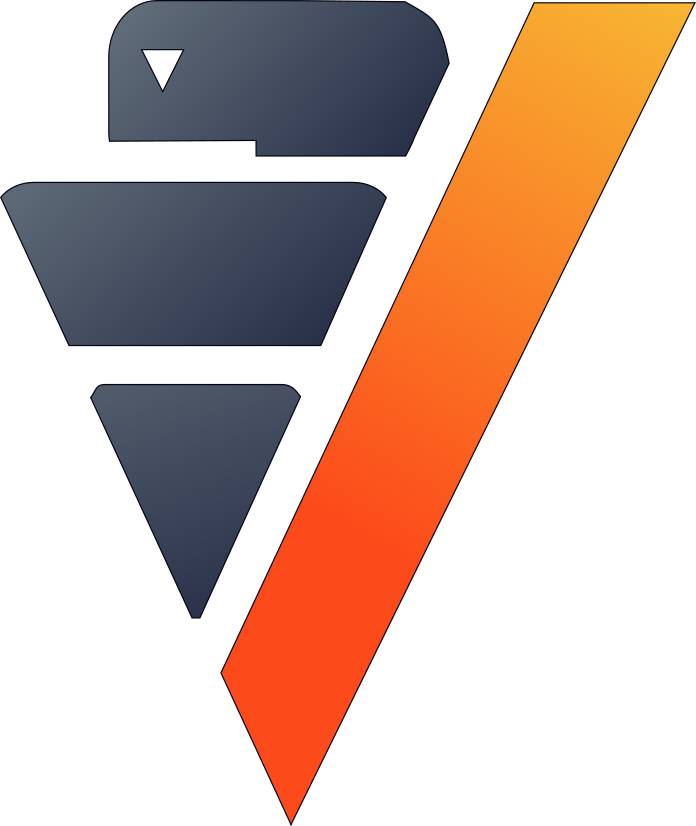

In [14]:
%sql select count(distinct device_id::int), max(value1::float) from events;

To understand intuitively, the materialized columns are created manually in the above. In fact, Vertica also provides functions COMPUTE_FLEXTABLE_KEYS, COMPUTE_FLEXTABLE_KEYS_AND_BUILD_VIEW and MATERIALIZE_FLEXTABLE_COLUMNS to automatically guess the data type of columns, build view with column names, and materialize frequent columns. For details, see [Materializing FlexTables](https://www.vertica.com/docs/latest/HTML/Content/Authoring/FlexTables/MaterializingFlexTables.htm).

#### 3.1.2 Optimization method 2: create an aggregated projection

[Live Aggregate Projection](https://www.vertica.com/docs/latest/HTML/Content/Authoring/AnalyzingData/AggregatedData/LiveAggregateProjections.htm) of Vertica, LAP, automatically stores the aggregated results of real-time data, which can usually reduce the number of blocks actually scanned during query, so improve query performance dramatically.

In [15]:
%%sql
create projection if not exists events_grp_device_id_max_value1 (
    device_id encoding RLE,
    max_value1
)
as 
select device_id,
  max(value1) as max_value1
from events
group by device_id;

select refresh('events');

CREATE
Refresh completed with the following outcomes:
Projection Name: [Anchor Table] [Status] [Refresh Method] [Error Count] [Duration (sec)]
----------------------------------------------------------------------------------------
"public"."events_grp_device_id_max_value1": [events] [refreshed] [scratch] [0] [5]



Run the same query again, usually gain another 2 orders of magnitude performance improvement.

,123countInteger,123maxFloat
1,10000,104.9067

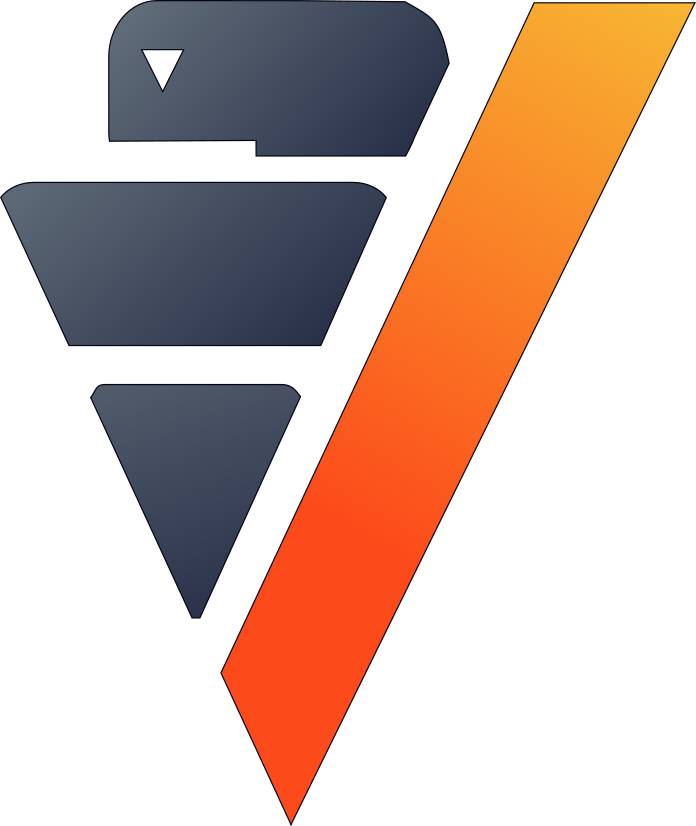

In [16]:
%sql select count(distinct device_id::int), max(value1::float) from events;

### 3.2 Aggregation at different time granularities

Data of sensors or buried points is usually time series. People not only query on the exact data points, sometimes the statistics of indicators at different time granularities such as minutes, 10 minutes, hours, days etc., are more convenient.

#### 3.2.1 Before optimization

For example, aggregate indicators by minute like below.

,📅timeDatetime,123value1Float,123value2Float
1,2022-03-27 08:43:00,-29.1907617647059,[null]
2,2022-03-27 08:44:00,-10.941435,[null]
3,2022-03-27 08:45:00,10.166580952381,[null]
4,2022-03-27 08:46:00,30.3930023809524,[null]
5,2022-03-27 08:47:00,47.7376952380952,[null]
6,2022-03-27 08:48:00,62.4975523809524,[null]
7,2022-03-27 08:49:00,73.4600707317073,[null]
8,2022-03-27 08:50:00,81.5694047619048,[null]
9,2022-03-27 08:51:00,87.6718952380952,[null]
10,2022-03-27 08:52:00,91.6336571428571,[null]

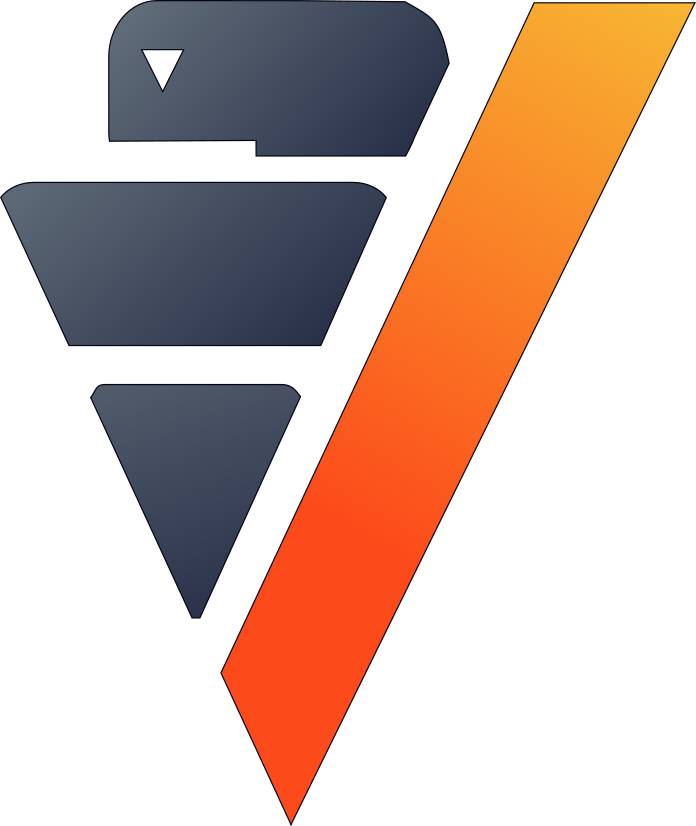

In [17]:
%%sql
select trunc(time, 'MI') as time
  , avg(value1::float) as value1 
  , avg(value2::float) as value2 
from events
where device_id = 0
group by 1
order by 1
;

#### 3.2.2 Create an aggregated projection at different time granularities

If this query is from a real-time dashboard or large screen data visualization, performance is expected as fast as possible, sub-seconds is perferred. Creating a aggregated projection according to aggregated time granularity and other dimensions can help achieve this goal.

Note, AVG aggregation in Vertica is internally calculated by SUM_FLOAT/COUNT.

In [18]:
%%sql
create projection if not exists events_grp_device_id_time_mi (
    device_id encoding RLE
    , time_mi
    , value1_count
    , value1_sum
    , value2_count
    , value2_sum
)
as 
select device_id
  , trunc(time, 'MI') as time_mi
  , count(value1::float) as value1_count
  , sum_float(value1::float) as value1_sum
  , count(value2::float) as value2_count
  , sum_float(value2::float) as value2_sum
from events
group by device_id
  , trunc(time, 'MI')
;

select refresh('events');

CREATE
Refresh completed with the following outcomes:
Projection Name: [Anchor Table] [Status] [Refresh Method] [Error Count] [Duration (sec)]
----------------------------------------------------------------------------------------
"public"."events_grp_device_id_time_mi": [events] [refreshed] [scratch] [0] [194]



There is usually 2 order of magnitude performance improvement when query with this aggregated projection.

,📅timeDatetime,123value1Float,123value2Float
1,2022-03-27 08:43:00,-29.0747117647059,-15.3159441176471
2,2022-03-27 08:44:00,-10.75996,-5.3710125
3,2022-03-27 08:45:00,10.3071619047619,5.14524047619048
4,2022-03-27 08:46:00,30.1671095238095,15.4347119047619
5,2022-03-27 08:47:00,48.2652166666667,25.8328571428571
6,2022-03-27 08:48:00,62.2291261904762,35.7548166666667
7,2022-03-27 08:49:00,73.3635658536585,45.322456097561
8,2022-03-27 08:50:00,81.9107690476191,54.4237666666667
9,2022-03-27 08:51:00,87.2705,62.885330952381
10,2022-03-27 08:52:00,91.6037476190476,70.670130952381

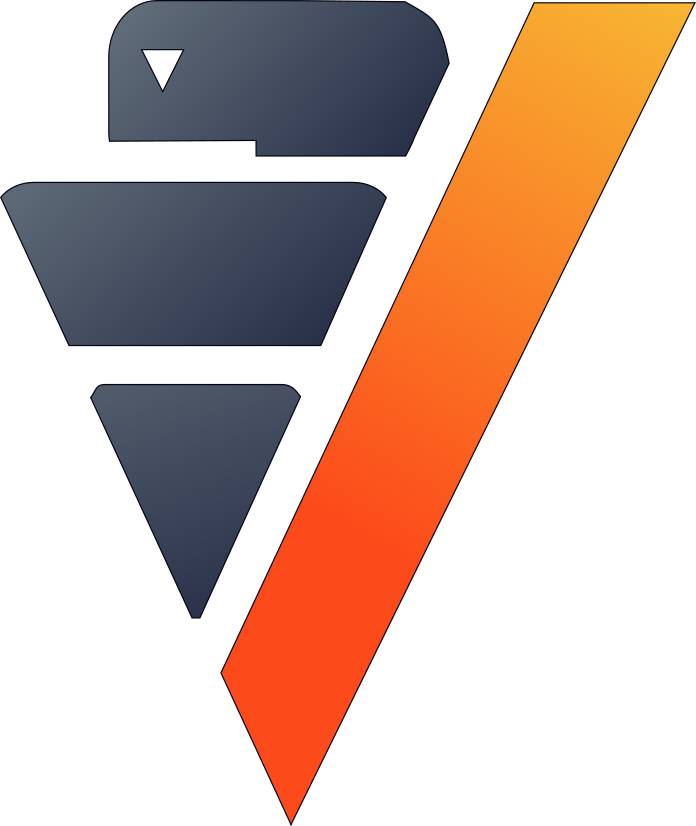

In [19]:
%%sql
select trunc(time, 'MI') as time
  , avg(value1::float) as value1 
  , avg(value2::float) as value2 
from events
where device_id = 0
group by 1
order by 1
;

According to this optimization, let's see the curve of aggregation by minute.

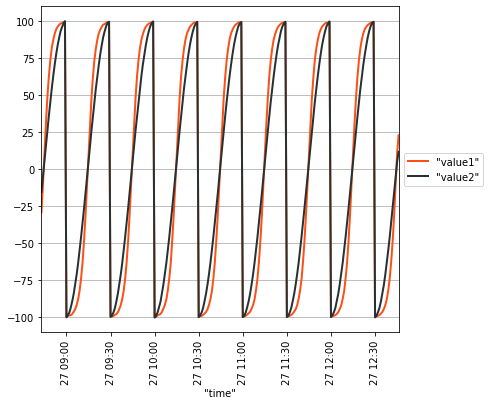

In [20]:
from verticapy import vdf_from_relation

vdf_from_relation("""(
select trunc(time, 'MI') as time
  , ifnull(avg(value1::float), 0) as value1 
  , ifnull(avg(value2::float), 0) as value2
from events 
where device_id = 1
group by 1
order by 1
) x""").plot(ts = "time", columns = ["value1", "value2"])

### 3.3 Get the latest data

To monitor manufacturing processes and alerts, sometimes only the latest data points are required, because it's a time-consuming & resource-waisting approach if all data points are still scanned in this situation.

#### 3.2.1 Before optimization

For example, only the latest 3 data points are required:

,123device_idInteger,📅timeDatetime,123valueFloat
1,0,2022-03-27 12:46:14.919596,24.9890666666667
2,1,2022-03-27 12:46:14.919596,24.1385666666667
3,2,2022-03-27 12:46:14.919596,25.2174
4,3,2022-03-27 12:46:14.919596,25.244
5,4,2022-03-27 12:46:14.919596,25.3334666666667
6,5,2022-03-27 12:46:14.919596,23.8856666666667
7,6,2022-03-27 12:46:14.919596,23.8675333333333
8,7,2022-03-27 12:46:14.919596,24.3220666666667
9,8,2022-03-27 12:46:14.919596,25.1300333333333
10,9,2022-03-27 12:46:14.919596,25.3739666666667

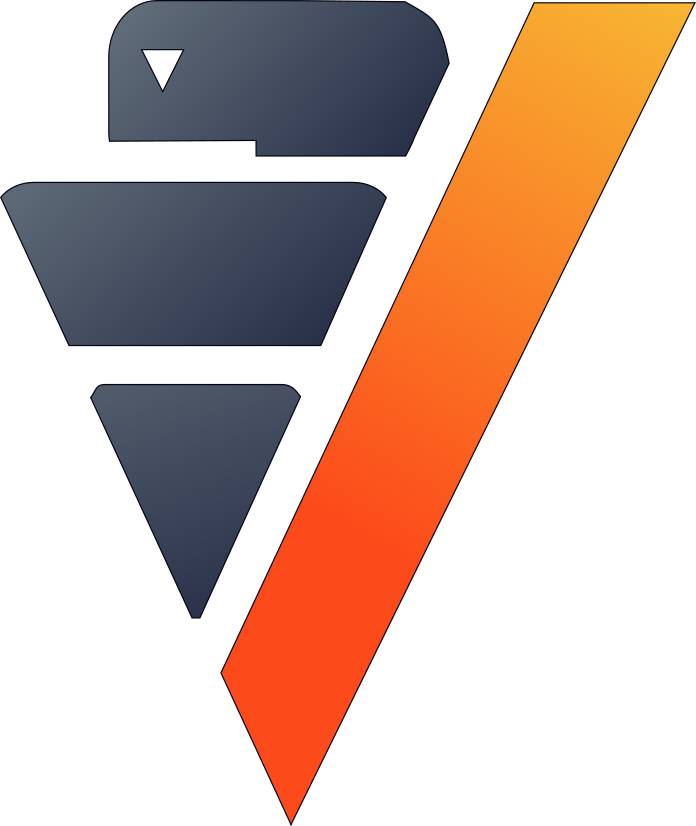

In [21]:
%%sql
select device_id, max(time) as time, avg(value1) as value from (
    select device_id, time, value1 from events
    limit 3 over(partition by device_id order by time desc) 
) t 
group by 1;

#### 3.3.2 Create TopK projection

[TopK Projections](https://www.vertica.com/docs/latest/HTML/Content/Authoring/AnalyzingData/AggregatedData/TopKQueryProjections.htm) of Vertica only store the top k rows of real-time data, that improves performance dramatically by reducing the number of data blocks to scan when querying.

In [22]:
%%sql
create projection if not exists events_top3_device_id_time_value1 (
    device_id encoding RLE
    , time
    , value1
)
as 
select device_id
  , time
  , value1
from events
limit 3 over(partition by device_id order by time desc)
;

select refresh('events');

CREATE
Refresh completed with the following outcomes:
Projection Name: [Anchor Table] [Status] [Refresh Method] [Error Count] [Duration (sec)]
----------------------------------------------------------------------------------------
"public"."events_top3_device_id_time_value1": [events] [refreshed] [scratch] [0] [4]



Running the same query again usually gain 2 orders of magnitude performance improvement.

,123device_idInteger,📅timeDatetime,123valueFloat
1,0,2022-03-27 12:46:14.919596,24.9890666666667
2,1,2022-03-27 12:46:14.919596,24.1385666666667
3,2,2022-03-27 12:46:14.919596,25.2174
4,3,2022-03-27 12:46:14.919596,25.244
5,4,2022-03-27 12:46:14.919596,25.3334666666667
6,5,2022-03-27 12:46:14.919596,23.8856666666667
7,6,2022-03-27 12:46:14.919596,23.8675333333333
8,7,2022-03-27 12:46:14.919596,24.3220666666667
9,8,2022-03-27 12:46:14.919596,25.1300333333333
10,9,2022-03-27 12:46:14.919596,25.3739666666667

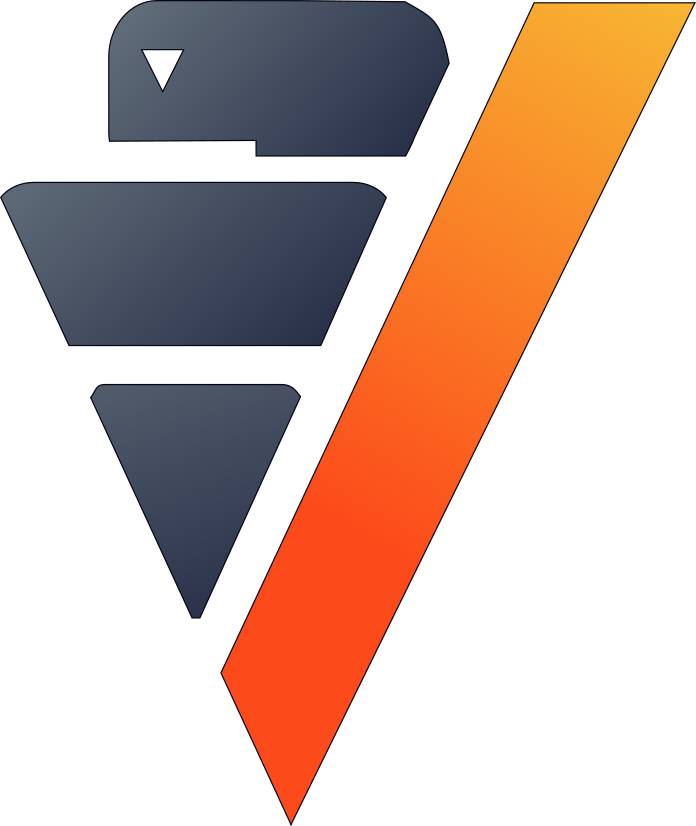

In [23]:
%%sql
select device_id, max(time) as time, avg(value1) as value from (
    select device_id, time, value1 from events
    limit 3 over(partition by device_id order by time desc) 
) t 
group by 1;

## 4. Machine learning

Vertica support loading data in real-time and also extremely fast analytical query performance. In fact, Vertica also has built-in rich data preparing and machine learning algorithms, which support quickly model training, testing, evaluation and predictive analysis in database with SQL.

Let's explore the curve of the time series with device_id = 1 at first.

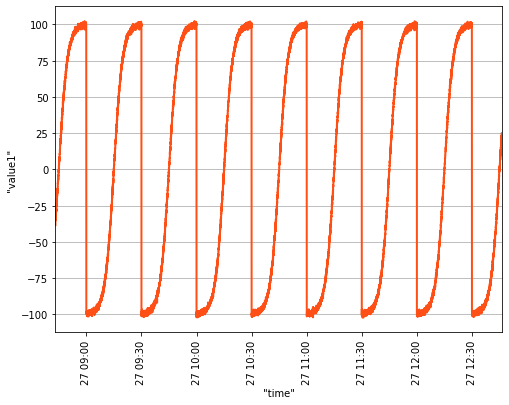

In [24]:
from verticapy import vdf_from_relation

vdf_from_relation("""(
select time
  , value1 
from events
where device_id = 1
order by 1
) x""").plot(ts = "time", columns = ["value1"], step = True)

There are obvious jumps in this curve. Let's divide it into different behavior sequences according to the jumps, that is [Sessionization](https://www.vertica.com/docs/latest/HTML/Content/Authoring/AnalyzingData/SQLAnalytics/SessionizationWithEvent-basedWindows.htm).

### 4.1 Get independent sequences with sessionization

First, the average value changes of adjacent points are taken as the basis for dividing different time series.

In [25]:
df = %sql select avg(abs(step)) as step from ( \
    select value1 - lag(value1) over(order by time) as step \
    from events \
    where device_id = 1) t;

step = df["step"][0]

The window function [CONDITIONAL_TRUE_EVENT](https://www.vertica.com/docs/latest/HTML/Content/Authoring/AnalyzingData/SQLAnalytics/SessionizationWithEvent-basedWindows.htm) can divide event points into separate series according to whether the indicators of adjacent points change significantly.

Here only the last serie will be kept for analysis.

In [26]:
df = %sql \
with ts (time, value1) as ( \
    select time, value1 \
    from events \
    where device_id = 1) \
select min(time) \
from ( \
    select time, value1 \
        , CONDITIONAL_TRUE_EVENT(abs(value1 - lag(value1)) > 10 * {step} ) \
        over(order by time desc) as session \
    from ts \
) t \
where session = 0 \
order by 1 ;

dtBegin = df["min"][0]

Let's see what this latest serie looks like.

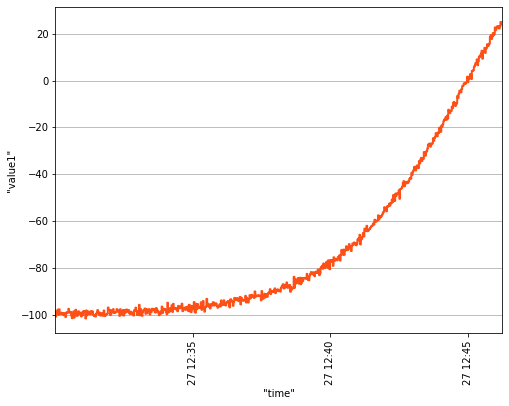

In [27]:
from verticapy import vdf_from_relation

df = vdf_from_relation(f"""(
select time
  , value1 
from events
where device_id = 1
  and time >= '{dtBegin}'
order by 1
) x""").plot(ts = "time", columns = ["value1"], step = True)

Here [Autoregressive Model](https://www.vertica.com/docs/latest/HTML/Content/Authoring/AnalyzingData/MachineLearning/TimeSeries/AutoregressorExample.htm) will be used for model training, testing and predict.

### 4.2 Data preparing and model training 

Since consistent timesteps are required by the autoregressive model, our time serie needs [Gap Filling and Interpolation](https://www.vertica.com/docs/latest/HTML/Content/Authoring/AnalyzingData/TimeSeries/GapFillingAndInterpolationGFI.htm) at first.

#### 4.2.1 Data preparing

Vertica has built-in time series processing functions. TIMESERIES syntax and the TS_FIRST_VALUE or TS_LAST_VALUE functions can finish gap filling & interpolation easily, the result is a view.

In [28]:
# linear Interpolation with 2 seconds steps here
%sql \
create or replace view events_device_1 as \
with ts(time, device_id, value1) as ( \
    select time \
        , device_id \
        , value1 \
        from events \
        where device_id = 1 \
            and time >= '{dtBegin}' \
) \
select time_slice as time \
    , device_id \
    , value1 \
from ( \
    select time_slice \
        , device_id \
        , TS_FIRST_VALUE(value1, 'LINEAR') as value1 \
    from ts \
    TIMESERIES time_slice AS '2 seconds' \
      OVER(PARTITION BY device_id ORDER BY time) \
) t;

CREATE


#### 4.2.2 Model training

The last few time steps are held out for testing later, and the rest of the data is used to train the model.
Vertica implements the model training and management as SQL functions or statements, which is very friendly to SQL.

In [29]:
# get the last step
df = %sql select max(time) from events_device_1;
maxTime = df["max"][0]

# hold out the latest 10 steps for testing, train model with steps before
%sql \
create or replace view events_device_1_train as \
select time \
  , value1 \
from events_device_1 \
where time <= (timestamp '{maxTime}' - 10 * interval '2 seconds') ;

# train model
%sql drop model if exists ar_events_device_1;

%sql select AUTOREGRESSOR('ar_events_device_1', \
                     'events_device_1_train', 'value1', 'time' \
                          using parameters p=3);
# show model
df = %sql \
select GET_MODEL_SUMMARY(using parameters model_name='ar_events_device_1');

print(df["GET_MODEL_SUMMARY"][0])

CREATE


DROP


Finished. 477 elements accepted, 1 elements rejected.





coefficients
parameter| value  
---------+--------
  alpha  | 1.46318
phi_(t-1)| 0.41600
phi_(t-2)| 0.31114
phi_(t-3)| 0.28652


mean_squared_error
not evaluated

timeseries_name
value1

timestamp_name
time

call_string
autoregressor('public.ar_events_device_1', 'events_device_1_train', 'value1', 'time'
USING PARAMETERS p=3, missing=linear_interpolation, regularization='none', lambda=1, compute_mse=false);

Additional Info
       Name       | Value  
------------------+--------
    lag_order     |   3    
      lambda      | 1.00000
rejected_row_count|   1    
accepted_row_count|  477   



### 4.3 Testing and predict the future

With a trained model, indicator predictions for future time points are quite easy now.

Here the actual indicator curve, the prediction results of the last 10 time points and the next 10 coming time points are plotted on the same graph.

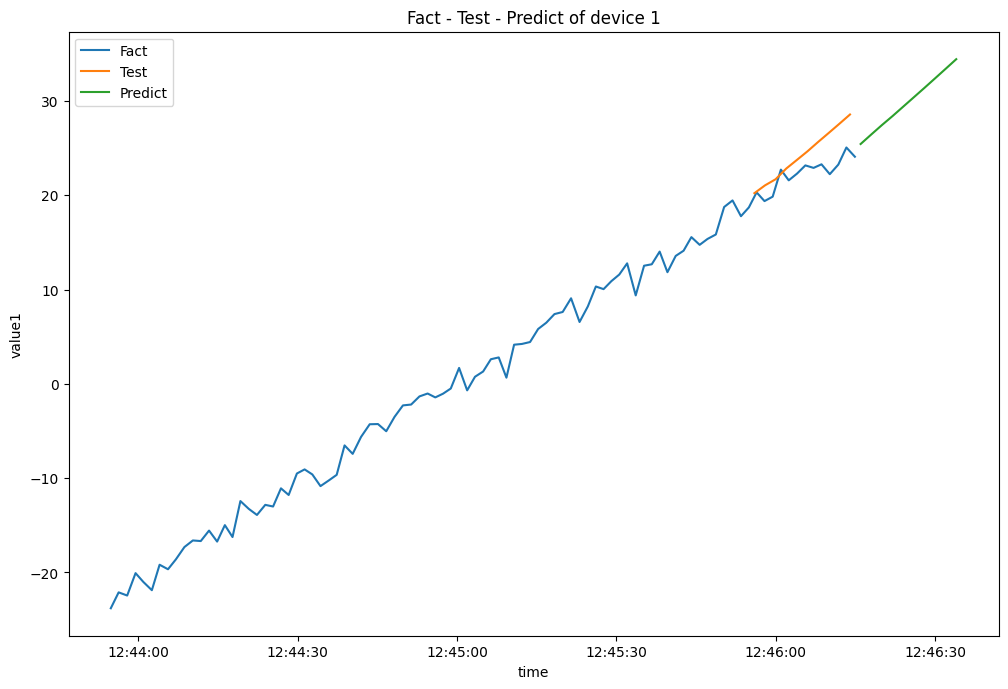

In [30]:
# get the last step
df = %sql select max(time) from events_device_1;
maxTime = df["max"][0]

from datetime import timedelta

# the latest 10 steps for testing
timeTest = [ maxTime + timedelta(seconds=2*(1+i)) for i in range(-10, 0)]

dfTest = %sql \
select PREDICT_AUTOREGRESSOR(value1 \
    using parameters model_name='ar_events_device_1', npredictions=10) \
        over(ORDER BY time) as value1 \
from events_device_1 \
where time <= (timestamp '{maxTime}' - 10 * interval '2 seconds') \
    and time > (timestamp '{maxTime}' - (10 + 3) * interval '2 seconds') ;

# the comming 10 steps for prediction
timePredict = [ maxTime + timedelta(seconds=2*(1+i)) for i in range(10)]

dfPredict = %sql \
select PREDICT_AUTOREGRESSOR(value1 \
    using parameters model_name='ar_events_device_1', npredictions=10) \
        over(ORDER BY time) as value1 \
from events_device_1 \
where time <= timestamp '{maxTime}' \
    and time > (timestamp '{maxTime}' - 3 * interval '2 seconds') ;

dfFact = %sql \
select time, value1 \
from events \
where device_id = 1 \
    and time > (timestamp '{maxTime}' - 70 * interval '2 seconds') \
order by time;


# show fact and test & predict result in same picture
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8), dpi= 100)

plt.plot(dfFact.to_numpy()[:, 0], dfFact.to_numpy()[:, 1], label='Fact')
plt.plot(timeTest, dfTest.to_numpy()[:, 0], label='Test')
plt.plot(timePredict, dfPredict.to_numpy()[:, 0], label='Predict')

plt.xlabel('time')
plt.ylabel('value1')

plt.title('Fact - Test - Predict of device 1')
plt.legend()
plt.show()

The predicted values of the last 10 time points are obviously close to the actual one and their trend are similar.

## 5. Summarizing

Near real-time loading of JSON semi-structured data, analytical queries optimization, model training and predictive analysis with in-database machine learning are shown above. In fact all of them are applicable to structured data and normal tables in Vertica.

Not just these!

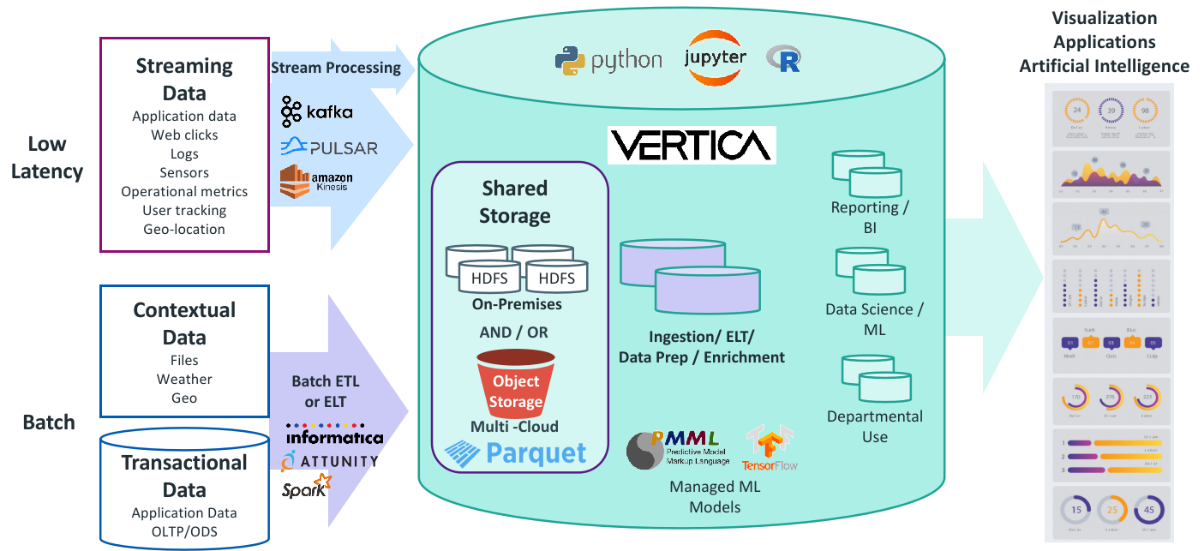

Vertica can be integrated with ETL tools such as Informatica, Attunity, Kettle, etc. It has a built-in connectors for Kafka and Spark for near real-time or batching data integration, and welcomes all kinds of BI and visualization tools such as Tableau, Qlik, MicroStrategy, etc. 
Vertica supports various platforms required by customers with an open architecture, in-place queries open data formats such as Parquet or ORC stored in data lakes like HDFS or S3 object storage without data moving, provides a unified analytics warehouse of big data, integrates all historical and the latest structured & semi-structured data distributed in data silos, supports near real-time predictive analysis and digital transformation of business and rapid innovation of data-driven business with comprehensive data and models including built-in machine learning and imported PMML/TensorFlow.